<table width="100%">
  <tr>
    <td>
      <h1 style="text-align: left; font-size:300%;">Homework 2 - Time Series forecasting challenge</h1>
      <table align="left">
        <tr>
          <td style="text-align: left;">Bottazzi Daniele</td>
          <td style="text-align: left;">10666960</td>
          <td style="text-align: left;"><a href="mailto:nouhaila.benhdidou@mail.polimi.it">daniele.bottazzi@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Resta Sara</td>
          <td style="text-align: left;">10667600</td>
          <td style="text-align: left;"><a href="mailto:daniele.bottazzi@mail.polimi.it">sara.resta@mail.polimi.it</a></td>
        </tr>
        <tr>
          <td style="text-align: left;">Saldarini Gaia</td>
          <td style="text-align: left;">10684442</td>
          <td style="text-align: left;"><a href="mailto:annalisa.imperiali@mail.polimi.it">gaia.saldarini@mail.polimi.it</a></td>
        </tr>
      </table>
    </td>
    <td width="20%">
      <div style="text-align: right">
          <br>
        <b style="font-size: 120%;">AN2DL course</b><br>
        <b>a.y. 2023-2024</b>
          <br><br>
        prof. M. Matteucci<br>
        prof. G. Boracchi<br>
      </div>
    </td>
  </tr>
</table>

# Exploratory Analysis
 Link to dowload the `training_dataset` used in this Notebook: in [.zip](https://drive.google.com/file/d/1WY9IFymDQ4KiGl1B6U4kJupiKk3YCBZH/view?usp=sharing) extension.

In this homework we are asked to predict future samples of the input time series. The goal is to design and implement forecasting models to learn how to exploit past observations in the input sequences to correctly predict the future. The task is to develop a forecasting model that is able to predict several uncorrelated time series.

The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

### Connect to Drive & Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/AN2DL/2023-2024/Homework 2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
!pip install fastdtw
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
import operator
from joblib import Parallel, delayed

## Dataset inspection:

Single folder `training_dataset` containing the following data:

- `training_data.npy` it contains a numpy array of shape `(48000, 2776)`. 48000 time series of length 2776.     
- `valid_periods.npy` it contains a numpy array of type `(48000, 2)` containing for each of the time series the start and end index of the current series, i.e. the part without padding.
- `categories.npy` it contains a numpy array of shape `(48000,)`, containing for each of the time series the code of its category. The possible categories are in `{'A', 'B', 'C', 'D', 'E', 'F'}`.

IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

## Time Series forecasting dataset
### Dataset Details:
#### Time series length
The length of the time series in the training dataset is variable. To simplify the portability of the dataset, we padded with zeros the sequences to the maximum length of `2776`. Thus, the dataset is provided in a compact form as a `Nx2776` array. We provide an additional `valid_periods.npy` file containing the information to recover the original time series without the padding.
File Format: npy

#### Categories
The provided time series are composed by sequences collected from 6 different sources. We further provide additional information about the category of each time series.

### Dataset Structure
Singel folder `training_dataset` containing the following data:

- `training_data.npy` it contains a numpy array of shape `(48000, 2776)`. `48000` time series of length `2776`.     
- `valid_periods.npy` it contains a numpy array of type `(48000, 2)` containing for each of the time series the start and end index of the current series, i.e. the part without padding.
- `categories.npy` it contains a numpy array of shape `(48000,)`, containing for each of the time series the code of its category. The possible categories are in `{'A', 'B', 'C', 'D', 'E', 'F'}`.

IMPORTANT: This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set.

In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'training_dataset.zip' file if the 'unzip' flag is True
if unzip:
    !unzip training_dataset.zip

In [ ]:
# Load dataset
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [ ]:
# Print the shapes of the loaded datasets
print("Training data Shape:", training_data.shape)
print("Valid periods data Shape:", valid_periods.shape)
print("Categories Shape:", categories.shape)

Training data Shape: (48000, 2776)
Valid periods data Shape: (48000, 2)
Categories Shape: (48000,)


In [ ]:
# Number of series to display
num_series = 5

def display_series(series, categories=None, num_series=5, last=500, ylim=None):
  fig, axes = plt.subplots(num_series, 1, figsize=(20, num_series * 1.8))
  for i in range(num_series):
      ax = axes[i]
      if categories is not None:
        ax.set_title(categories[i])
      ax.plot(series[i][-last:])

  # Adjust layout and display the images
  if ylim is not None:
    plt.ylim(ylim)
  plt.tight_layout()
  plt.show()

###Categories

The provided time series are composed by sequences collected from 6 data different sources:
- demography,
- finance,
- industry,
- macro-economy,
- micro-economy,
- other.

In [ ]:
# Inspect the dataset
np.unique(categories, return_counts = True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([ 5728, 10987, 10017, 10016, 10975,   277]))

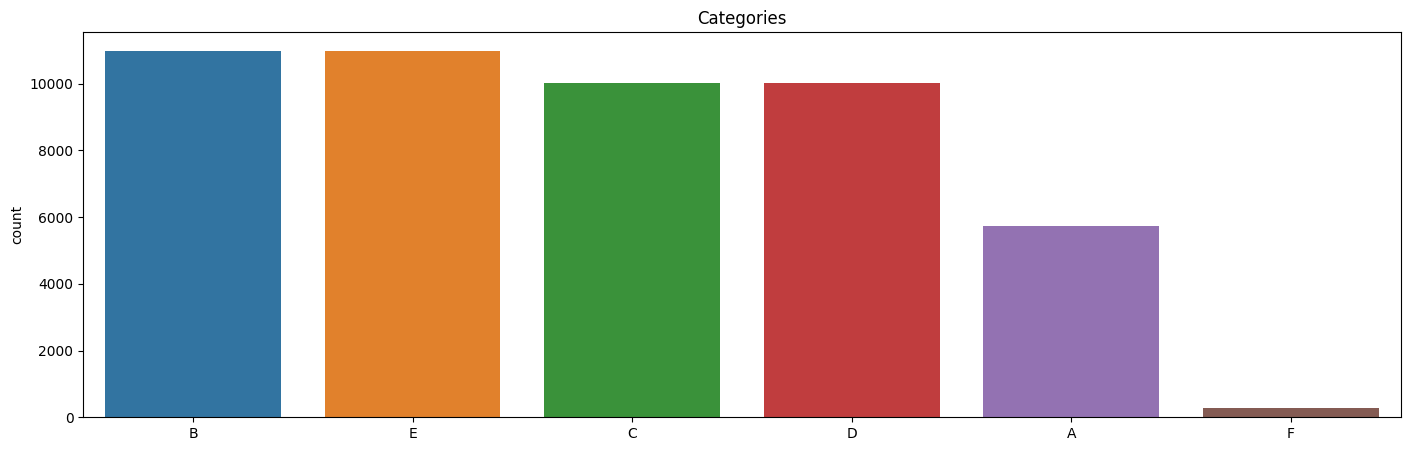

In [ ]:
# Inspect Categories
categories_series = pd.Series(categories)
categories_sorted = categories_series.value_counts().index.tolist()
plt.figure(figsize=(17, 5))
sns.countplot(x=categories_series, order=categories_sorted)
plt.title('Categories')
plt.show()

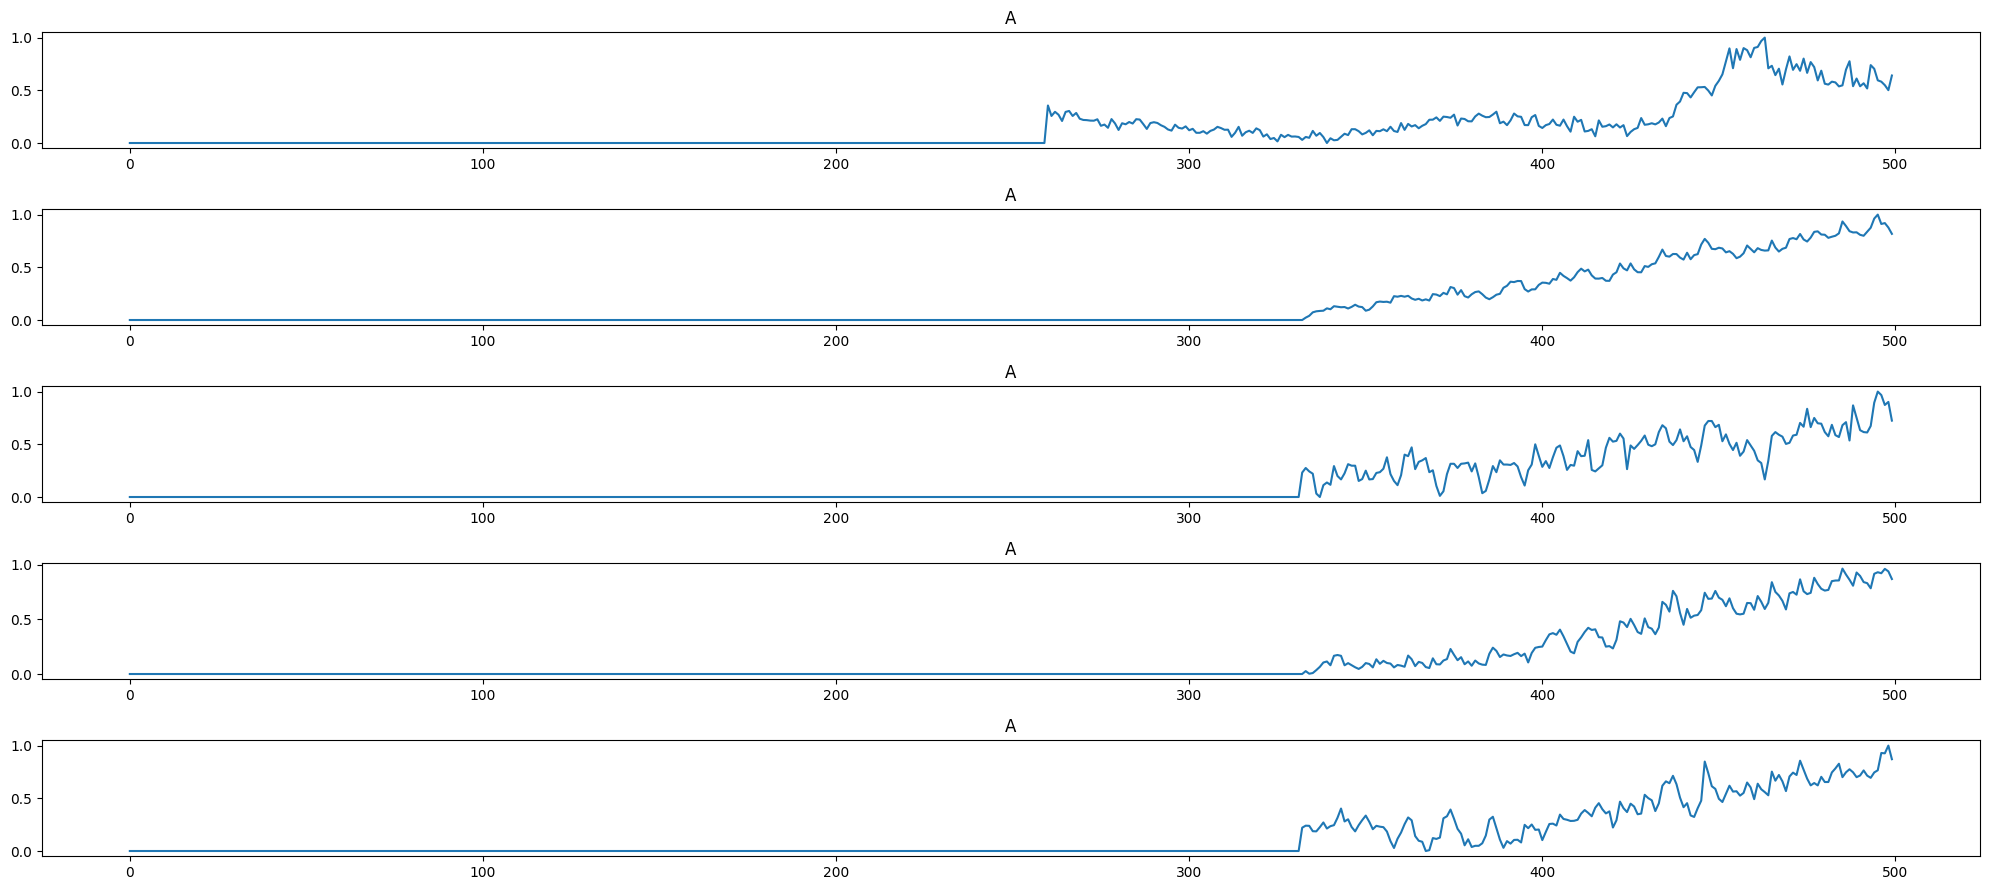

In [ ]:
display_series(training_data[categories=="A"], categories[categories=="A"])

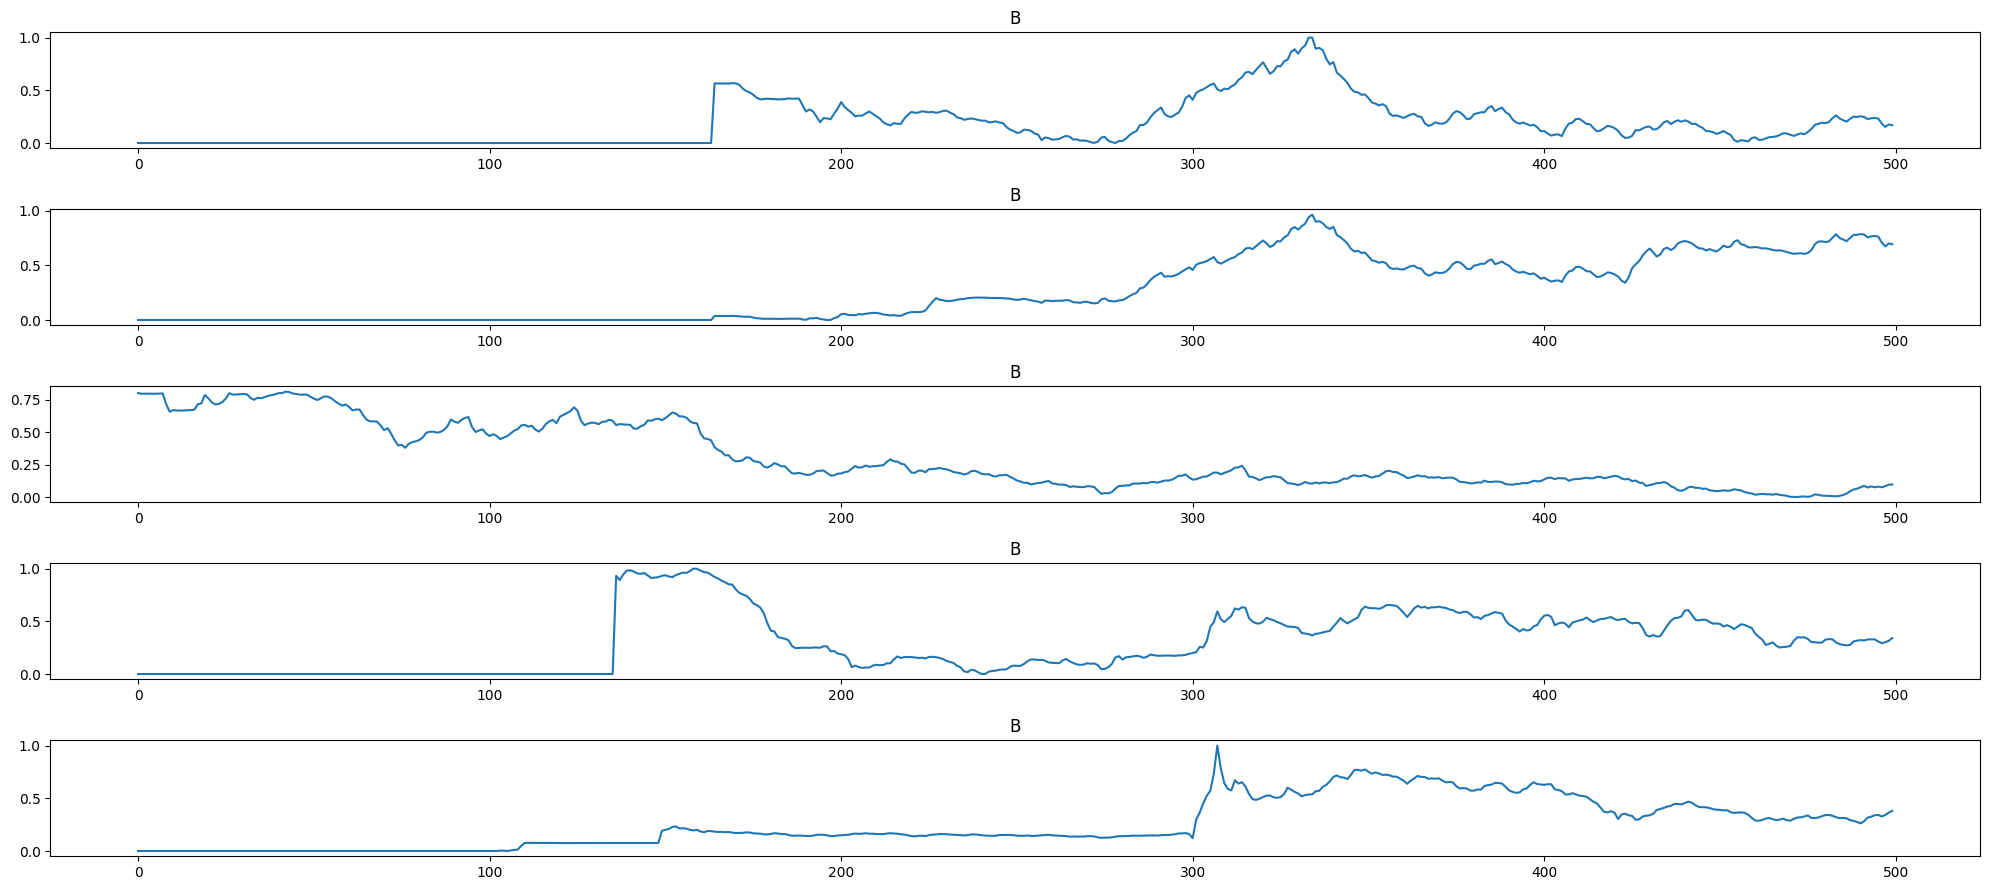

In [ ]:
display_series(training_data[categories=="B"], categories[categories=="B"])

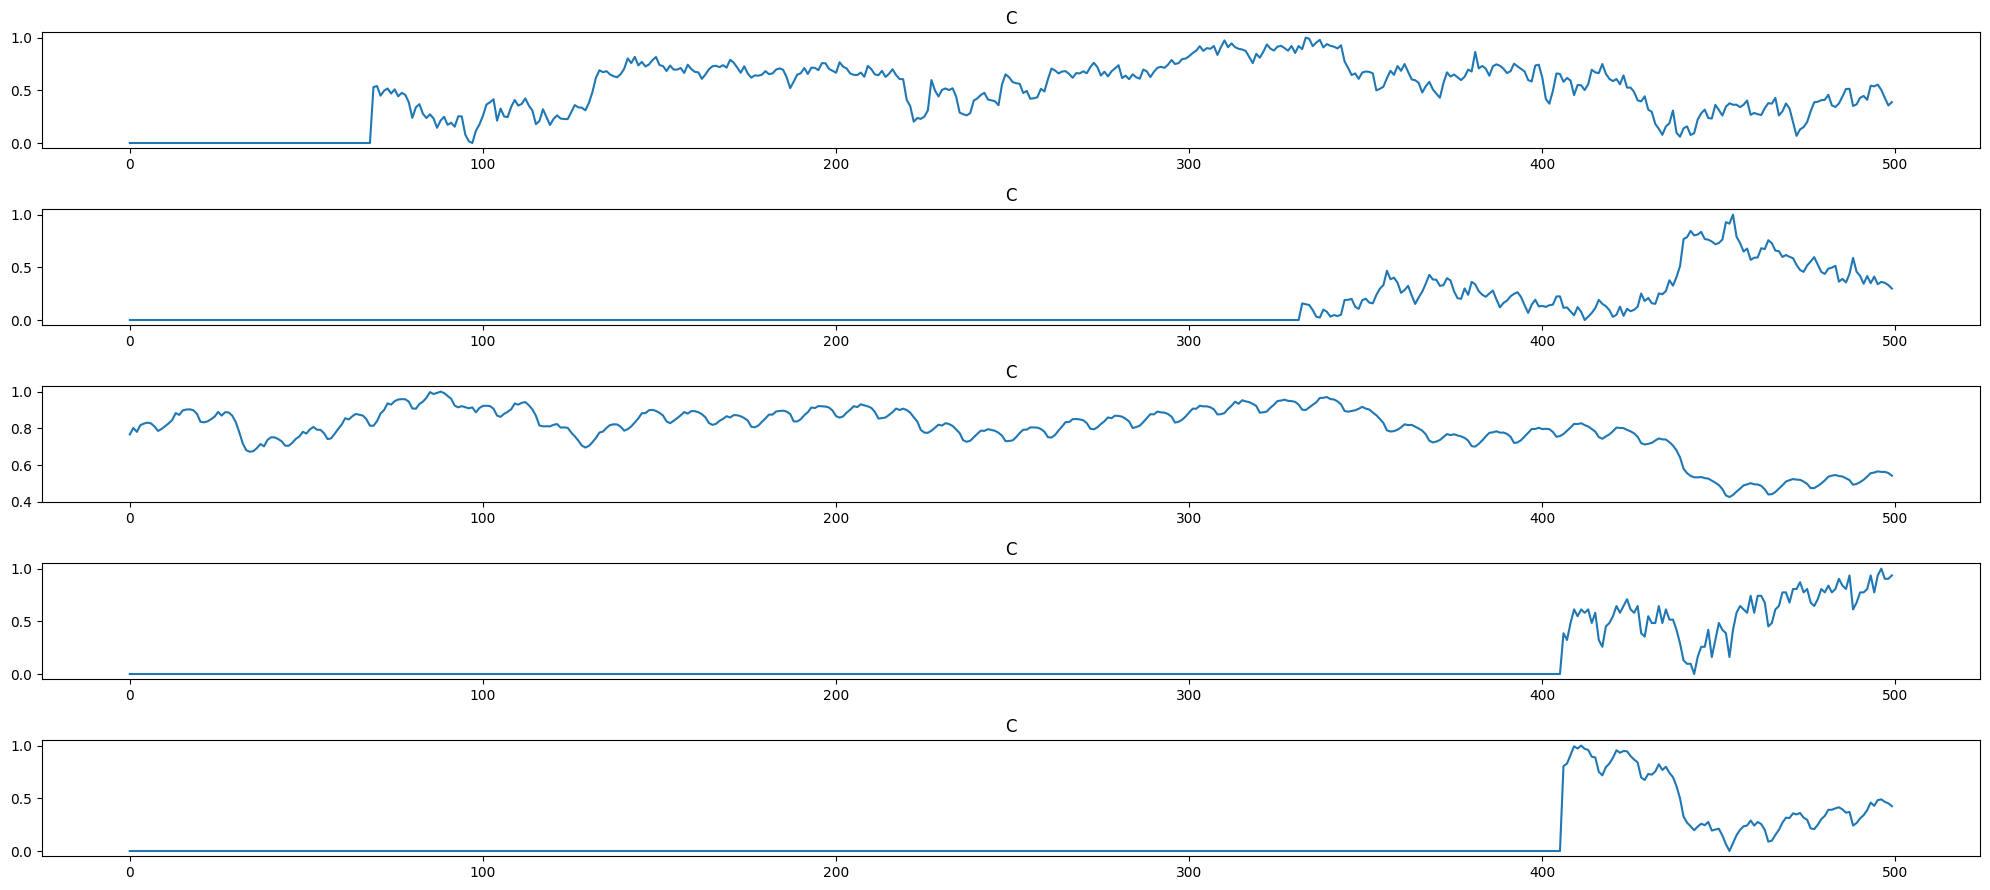

In [ ]:
display_series(training_data[categories=="C"], categories[categories=="C"])

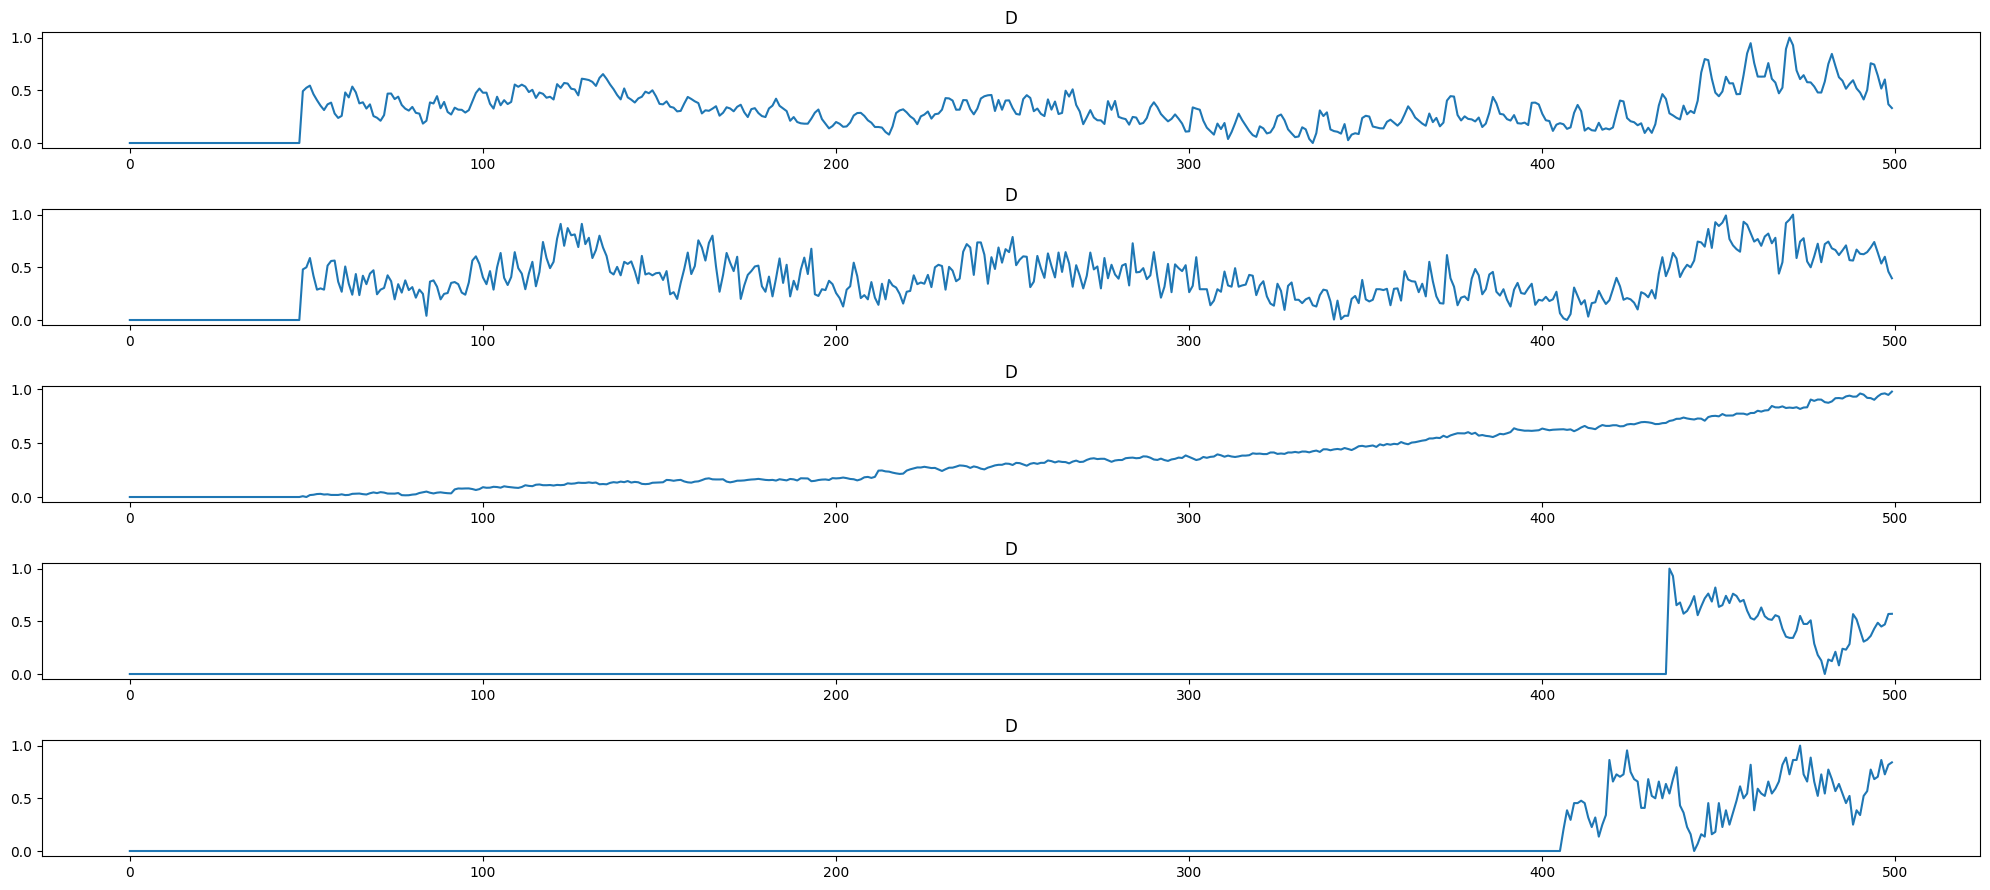

In [ ]:
display_series(training_data[categories=="D"], categories[categories=="D"])

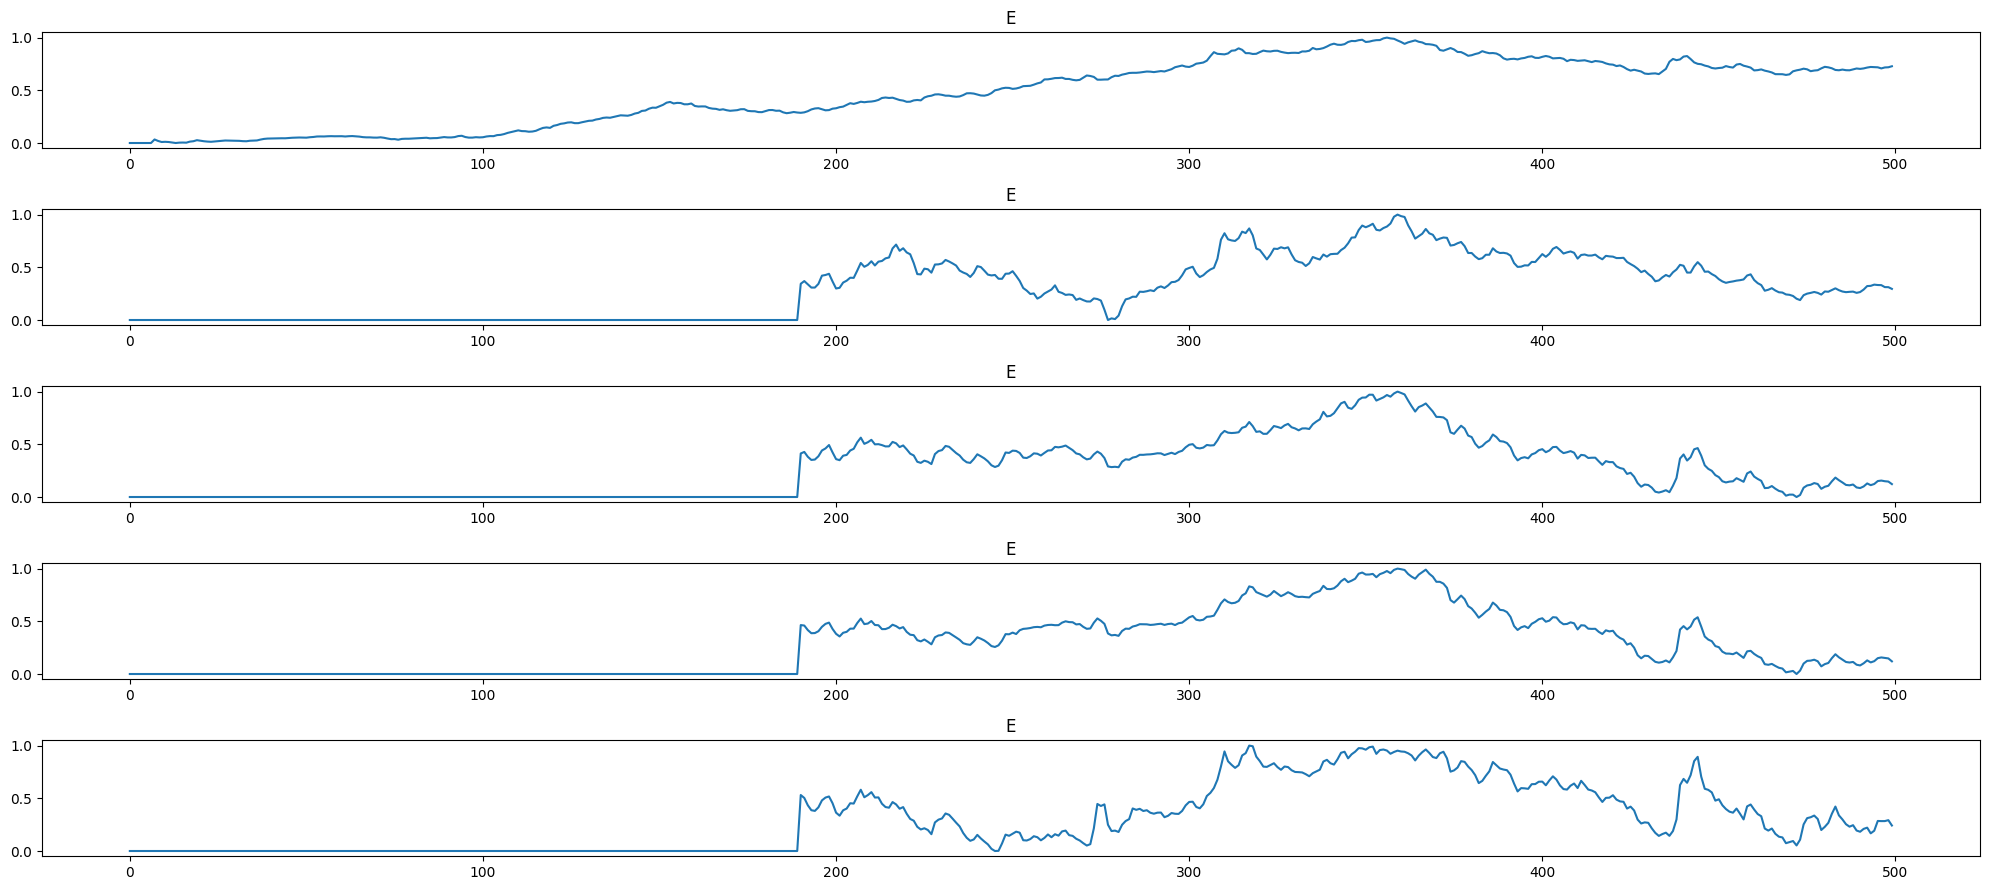

In [ ]:
display_series(training_data[categories=="E"], categories[categories=="E"])

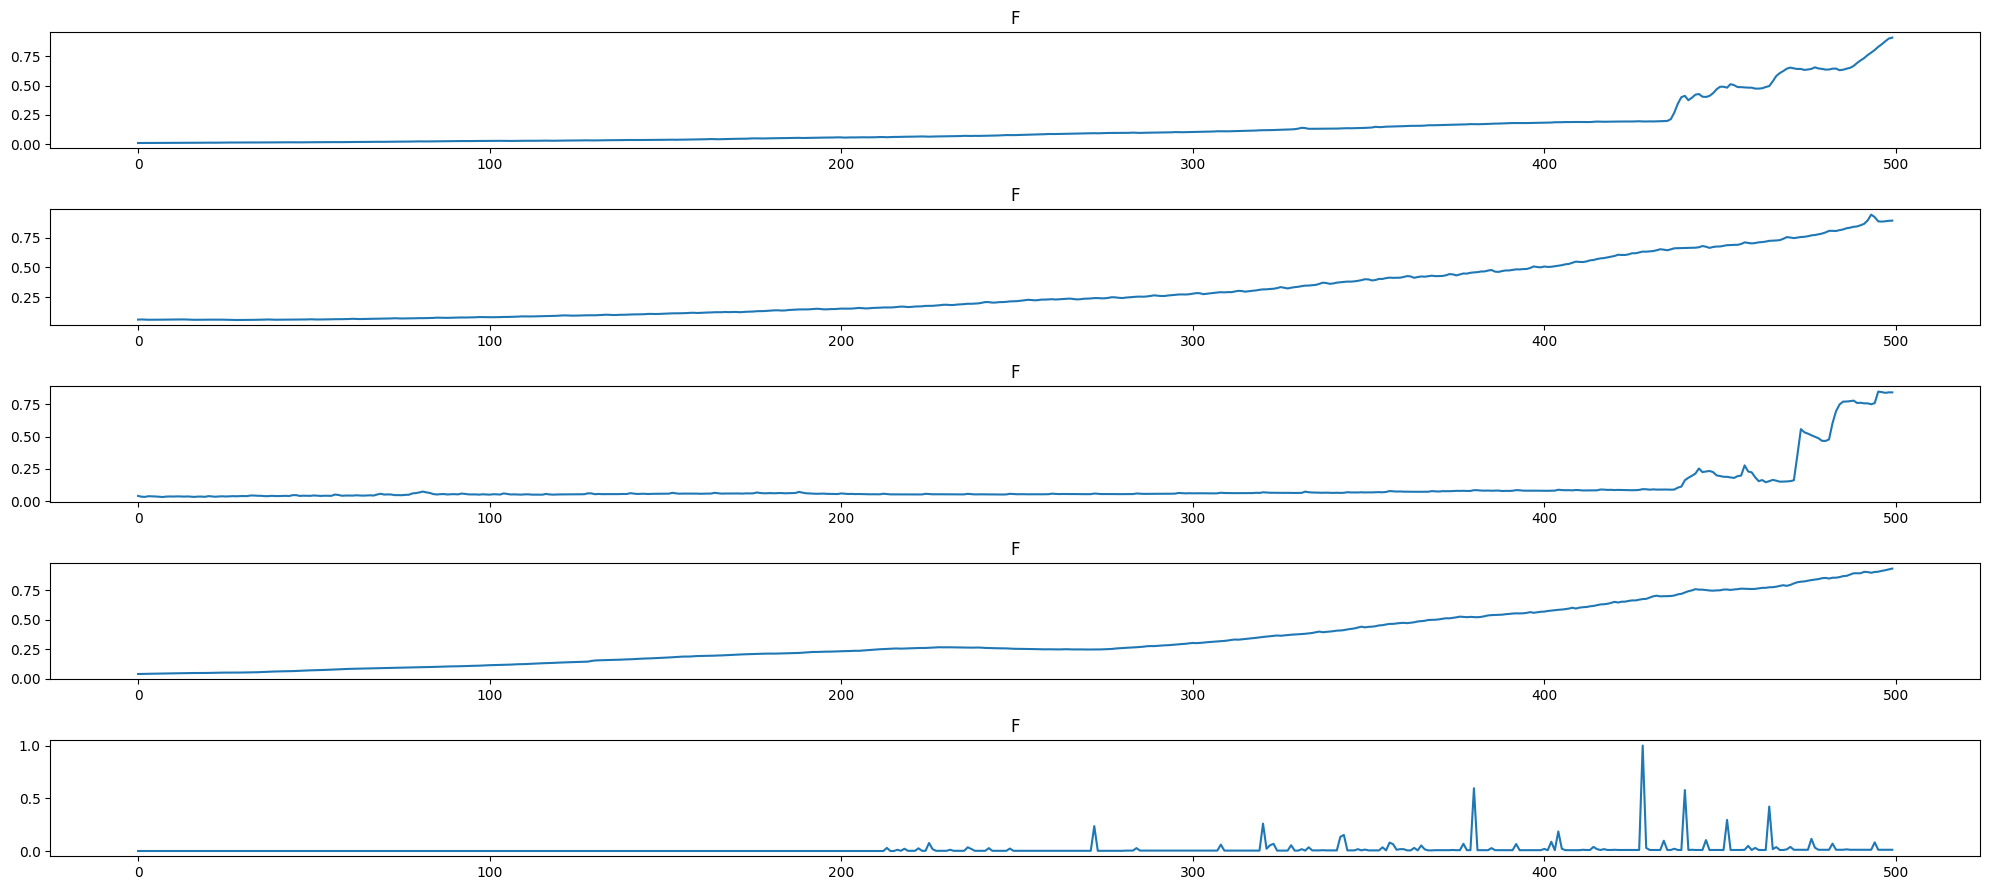

In [ ]:
display_series(training_data[categories=="F"], categories[categories=="F"])

The series are uniformly distributed in `'B'`, `'C'`, `'D'`, `'E'` categories (around 10.000 each), while `'A'` has half of them and `'F'` is highly over-represented with only 277 series (balance). By inspecting them, categories seem to have heterogeneous patterns, so the classification seems to be not significant for the series' characteristics: each category is a collection of series taken from similar data sources, which doesn't mean the series themselves are closely related.

By inspecting the series, we see they have heterogeneous patterns: they can be ascending, descending, smooth, noisy, spiked.

### Series' length


The length of the time series in the training dataset is variable. To simplify the portability of the dataset, the sequences are padded with zeros to the maximum length of 2776. Thus, the dataset is provided in a compact form as a `N x 2776` array. The additional `valid_periods.npy` file contains the information to recover the original time series without the padding.



In [ ]:
# Valid periods end
np.unique(valid_periods[:, 1])

array([2776])

The end of the valid periods is always 2776, therefore padding was added only at the beginning of shorter time series.

In [ ]:
# Distribution of time series length
length = valid_periods[:, 1] - valid_periods[:, 0]

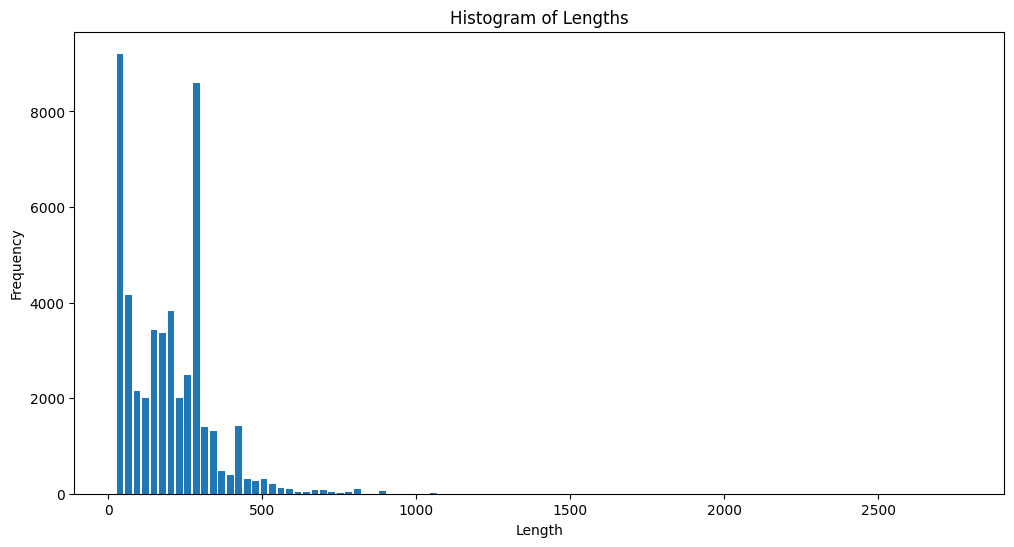

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(length, bins = 100, rwidth  = 0.8)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths')
plt.show()

In [ ]:
print(f"{sum(length <= 500)} time series are shorter than 500, i.e. the {(sum(length<=500)/len(length) * 100):.2f} %")

46879 time series are shorter than 500, i.e. the 97.66 %


Let's look at the length distribution more in detail, in length's range 0-500, which contains the vast majority of the time series.

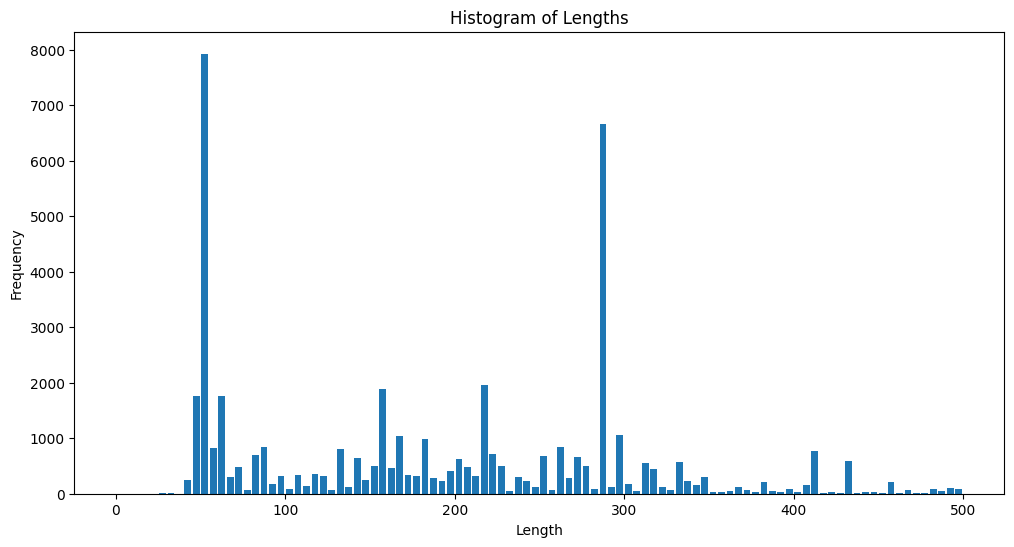

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(length, bins = 100, range=(0, 500), rwidth  = 0.8)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths')
plt.show()

In [ ]:
# Looking at the mode and most frequent lengths
elem, count = np.unique(length, return_counts = True)
ascending = np.argsort(count)
descending = ascending[::-1]
idx = descending[0:3]
elem[idx]

array([ 51, 288, 157])

In [ ]:
# Min and Max length
print(f"Minimum length: {min(length)}")
print(f"Maximum length: {max(length)}")

Minimum length: 24
Maximum length: 2776


In [ ]:
# Average
print(f"Average length: {np.mean(length):.2f}")

Average length: 198.30


Series length distribution is highly heterogeneous, going from a minimum of 24 to max of 2776; the mode is very low (51). This must be taken into account in the building of the sequences, otherwise many of them will be padded with 0s.  

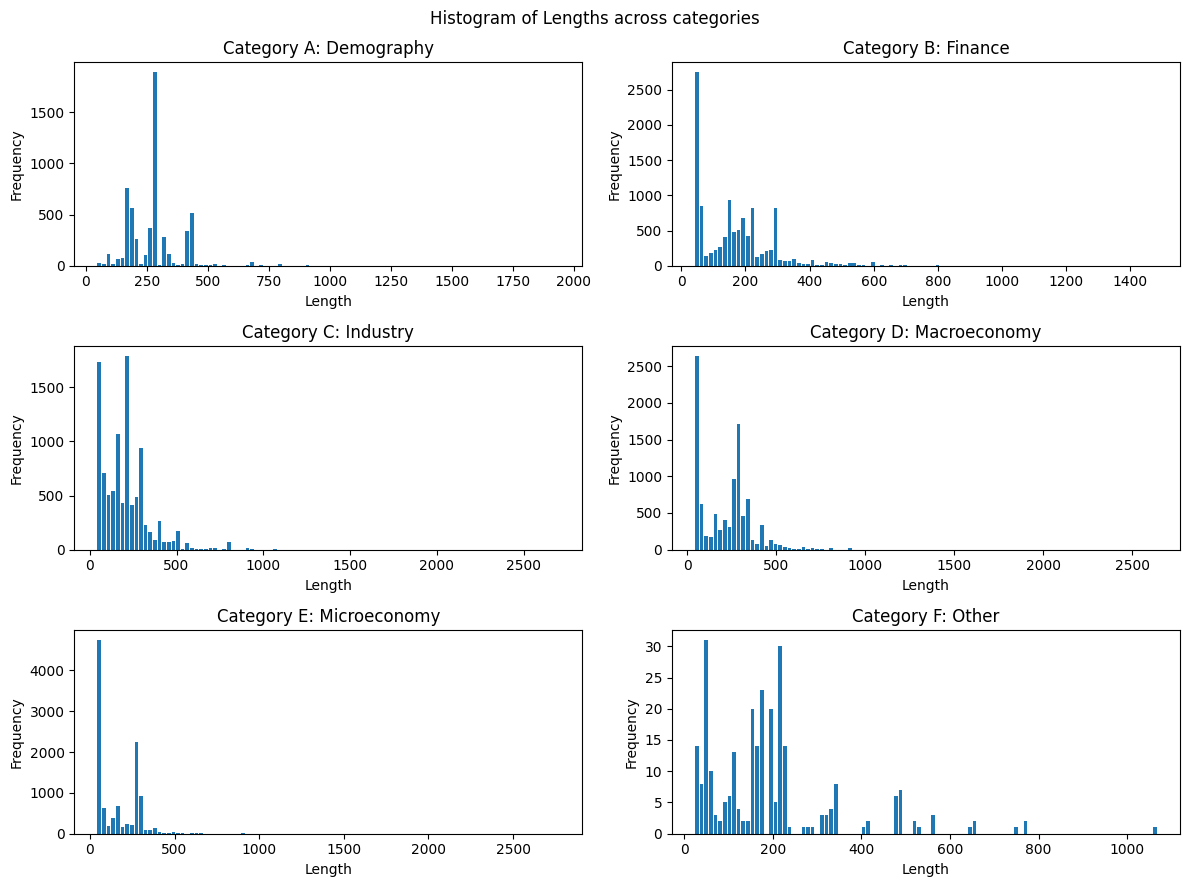

In [ ]:
# Inspection the series length distribution among categories

# Rename the categories as specified
category_mapping = {
    'A': 'A: Demography',
    'B': 'B: Finance',
    'C': 'C: Industry',
    'D': 'D: Macroeconomy',
    'E': 'E: Microeconomy',
    'F': 'F: Other'
}

# Apply the renaming to the categories
categories_series_mapped = categories_series.map(category_mapping)

# Group the lengths based on the renamed categories
grouped_lengths = {category: length[categories_series_mapped == category] for category in sorted(categories_series_mapped.unique())}

# Calculate the number of rows and columns for the subplot layout
num_categories = len(grouped_lengths)
num_rows = 3
num_cols = (num_categories + 1) // num_rows

# Create the subplot grid for the plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Flatten the axes array if the number of categories is less than the grid's capacity
axes = axes.flatten()

# Iterate through the categories and plot the histograms
for i, (category, data) in enumerate(grouped_lengths.items()):
    ax = axes[i]  # Select the current axis
    ax.hist(data, bins=100, rwidth  = 0.8)  # Plot the histogram for the current category
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Category {category}')  # Add the title for each category

# Hide the unused axes and adjust the layout
for i in range(num_categories, num_rows * num_cols):
    axes[i].axis('off')

fig.suptitle('Histogram of Lengths across categories')
plt.tight_layout()
plt.show()

## Data preprocessing

In [ ]:
# Check duplicates
unique_series, unique_indices, counts = np.unique(training_data, axis=0, return_index=True, return_counts=True)

In [ ]:
if len(unique_series) < len(training_data):
    duplicated_indices = unique_indices[counts > 1]
    print(f"{len(unique_series)} unique series found, {duplicated_indices.shape[0]} duplicates.\n\nDuplicated indices: {duplicated_indices}")
else:
    print("No duplicates")

47974 unique series found, 26 duplicates.

Duplicated indices: [44934 27255 36768  6191 42175 42654 42958 43055 45340 33257 42963 33421
 34389 34504 45368 45387 26714 17124 44756 17122 45513 27617 42277  2973
 36029  6802]


In [ ]:
# Remove duplicates
unique_series.shape
unique_categories = categories[unique_indices]
unique_valid_periods = valid_periods[unique_indices]

In [ ]:
print(unique_series.shape)
print(unique_categories.shape)
print(unique_valid_periods.shape)

(47974, 2776)
(47974,)
(47974, 2)


In [ ]:
np.save("unique_series.npy", unique_series)
np.save("unique_categories.npy", unique_categories)
np.save("unique_valid_periods.npy", unique_valid_periods)

In [ ]:
del unique_indices, counts

In [ ]:
length = unique_valid_periods[:, 1] - unique_valid_periods[:, 0]

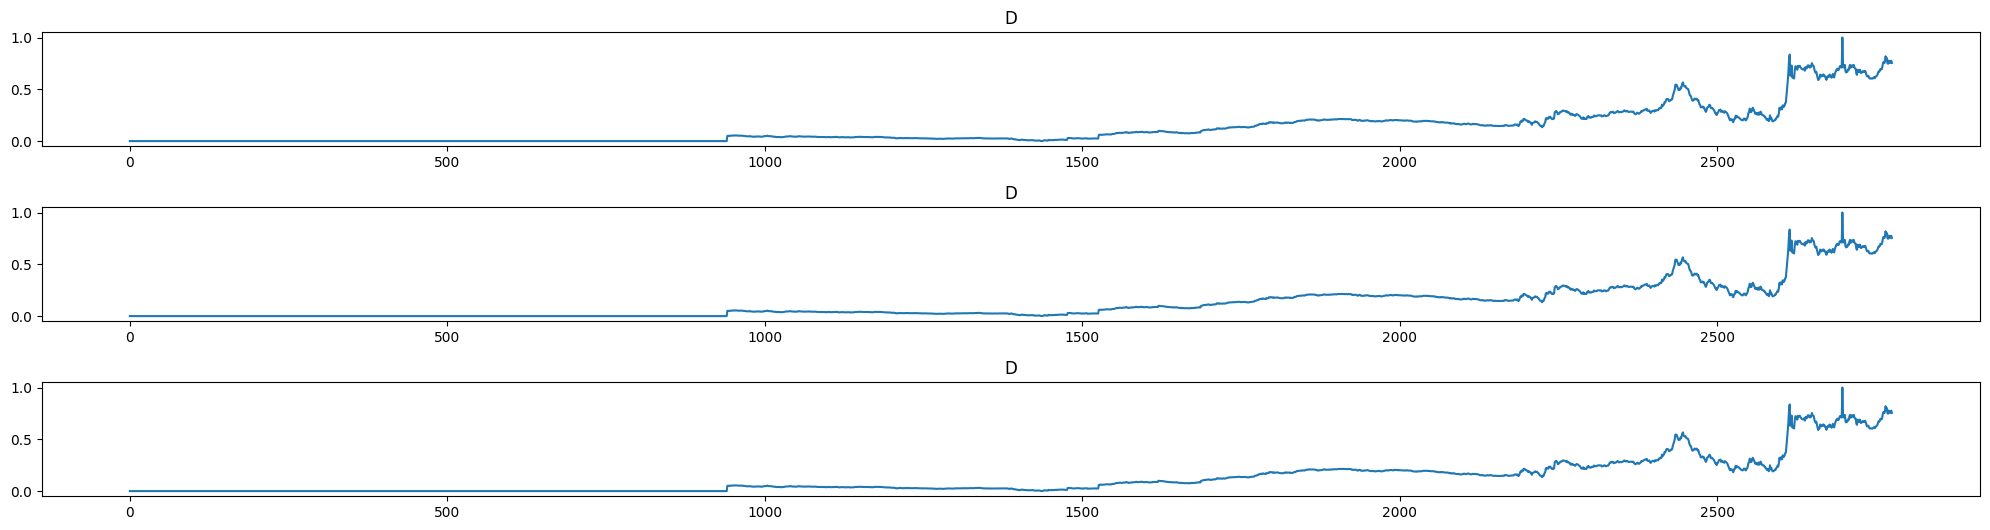

In [ ]:
display_series(unique_series[length > 1500][2:5], unique_categories[length > 1500][2:5], last=unique_series.shape[1], num_series=3)

In [ ]:
unique_series[length > 1500][2:5]

array([[0.        , 0.        , 0.        , ..., 0.77281995, 0.77587829,
        0.75431305],
       [0.        , 0.        , 0.        , ..., 0.7731456 , 0.77621332,
        0.75466058],
       [0.        , 0.        , 0.        , ..., 0.77347325, 0.77655042,
        0.75501026]])

26 duplicates are removed, but there might also be some equal but shifted series, hardly recognizable due to the scaling, for example these 3 series, which by eye look the same and have only some slightly different values.

In [ ]:
# Remove padding from unique series
valid_series = np.array([row[start:end+1] for row, (start, end) in zip(unique_series, unique_valid_periods)])
valid_series[0].shape

(25,)

###Normalization

In [ ]:
print(np.any(unique_series < 0))
print(np.any(unique_series > 1))
print(np.min(np.max(unique_series, axis=1)))
print(np.max(np.min(unique_series, axis=1)))

False
False
0.017374517374517374
0.06064118821772988


Each row of the dataset has been normalized to the range [0,1] independently of the other rows. It has been normalized starting from the original time series, that have been cut after the normalization to create the final training dataset with a shorter length. Min and max may be different from 0 and 1.

We try 3 different scalers:
- `MinMaxScaler`, which scales and translates each feature individually between zero and one, should give very slight changes; also it doesn't reduce the effect of outliers but scales them down into the fixed range.  
- `StandardScaler`, which standardizes features by centering (remove the mean) and scaling to unit variance. It behaves well if the data is approximately normally distributed and is sensitive to outliers.
- `RobustScaler`, which scales features using statistics that are robust to outliers, by removing the median and scaling data according to the interquartile range.

They are applied only on the valid part of the series, while padding remains at 0 and is not counted.

In [ ]:
def apply_scaling(matrix, valid_periods, scaler):
    num_rows, num_cols = matrix.shape
    result_matrix = np.zeros_like(matrix, dtype=float)

    for i in range(num_rows):
        start_index = valid_periods[i, 0]
        end_index = valid_periods[i, 1]

        # Extract the non-padded part of the time series
        series = matrix[i, start_index:end_index]

        # Reshape to a 2D array for scaling
        series_reshaped = series.reshape(-1, 1)

        # Scaling
        series_scaled = scaler.fit_transform(series_reshaped)

        # Assign the scaled values back to the result matrix
        result_matrix[i, start_index:end_index] = series_scaled.flatten()

    return result_matrix

In [ ]:
minmax_scaler = MinMaxScaler()
zscore_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [ ]:
minmax_scaled_matrix = apply_scaling(unique_series, unique_valid_periods, minmax_scaler)
zscore_scaled_matrix = apply_scaling(unique_series, unique_valid_periods, zscore_scaler)
robust_scaled_matrix = apply_scaling(unique_series, unique_valid_periods, robust_scaler)

In [ ]:
idx = np.where((np.max(unique_series, axis=1)) < 0.20)
idx = idx[0:2]

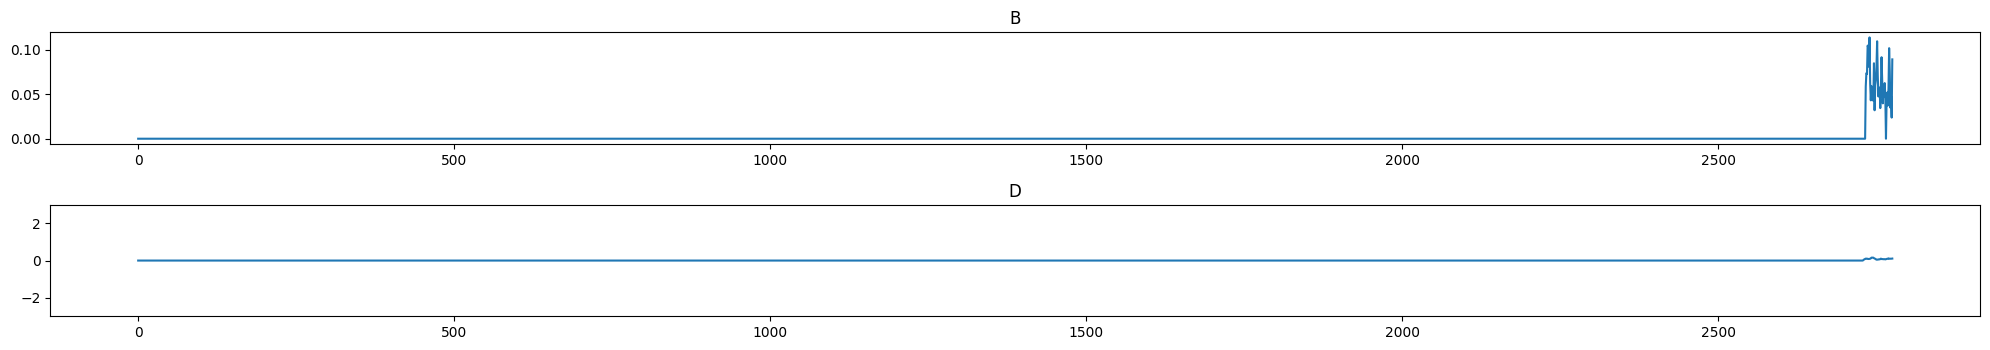

In [ ]:
# Original
display_series(unique_series[idx], unique_categories[idx], last=unique_series[idx].shape[1], num_series=2, ylim=(-3, 3))

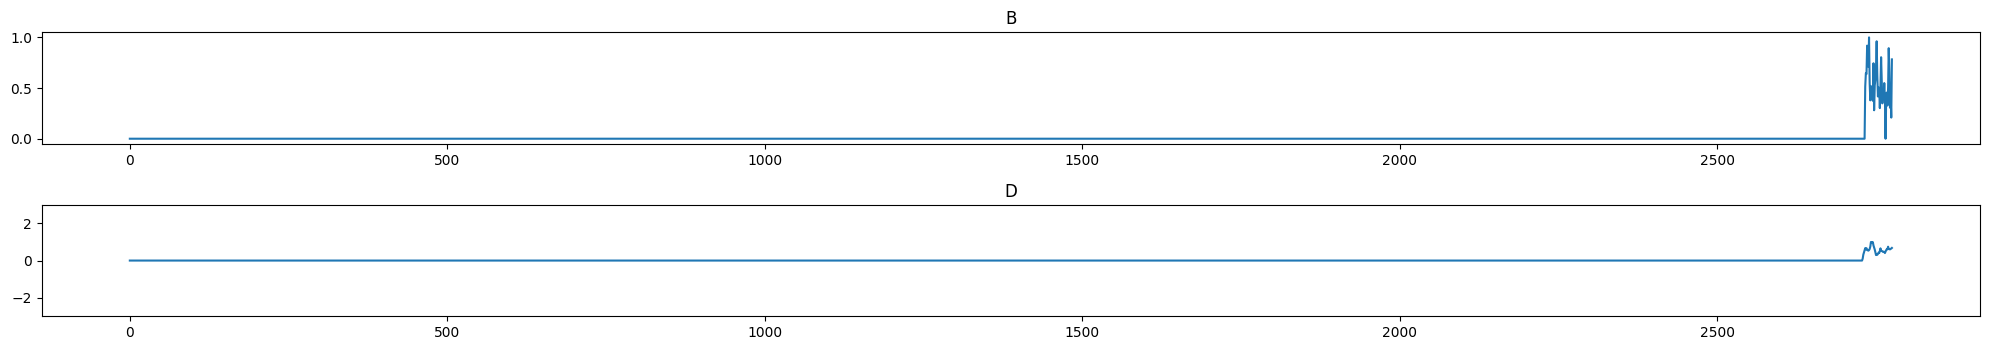

In [ ]:
# MinMaxScaler
display_series(minmax_scaled_matrix[idx], unique_categories[idx], last=unique_series[idx].shape[1], num_series=2, ylim=(-3, 3))

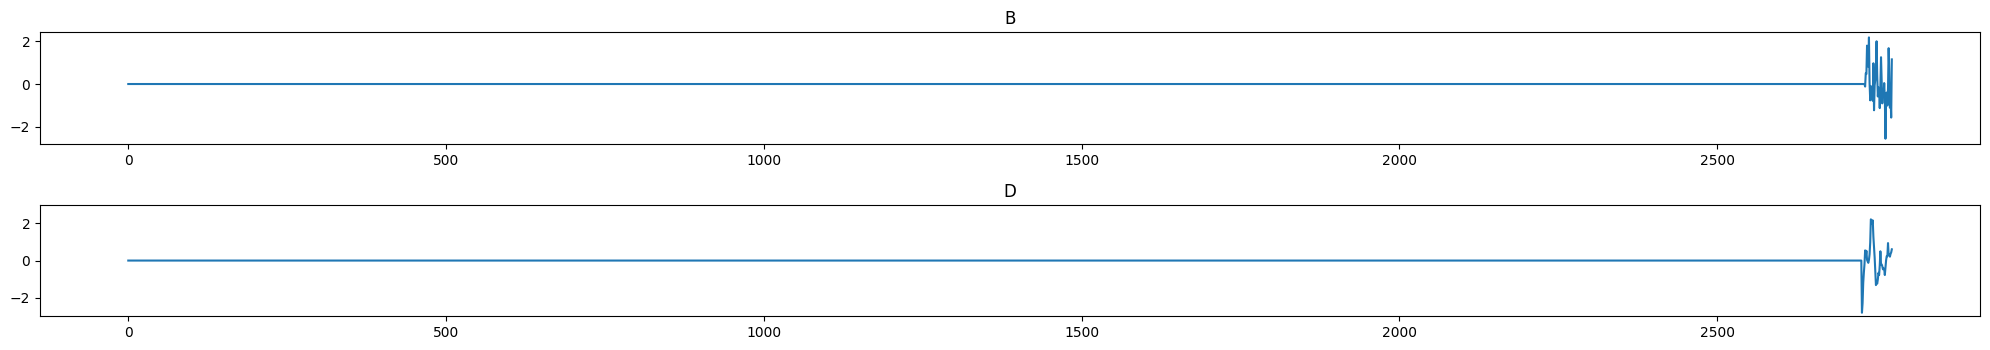

In [ ]:
# StandardScaler
display_series(zscore_scaled_matrix[idx], unique_categories[idx], last=unique_series[idx].shape[1], num_series=2, ylim=(-3, 3))

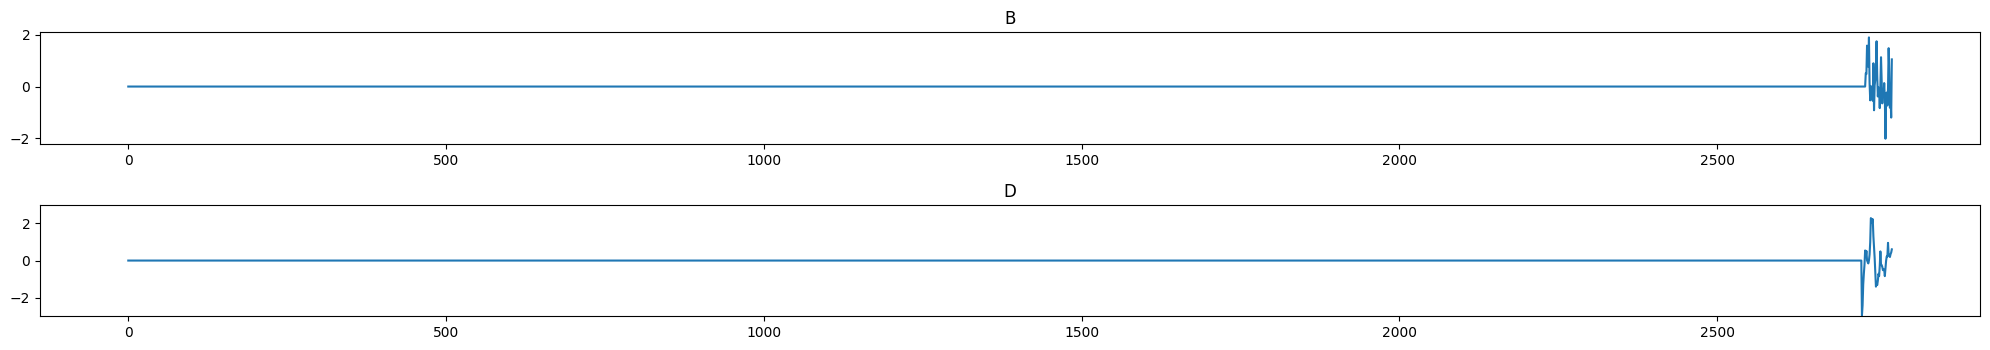

In [ ]:
# RobustScaler
display_series(robust_scaled_matrix[idx], unique_categories[idx], last=unique_series[idx].shape[1], num_series=2, ylim=(-3, 3))

In [ ]:
del minmax_scaled_matrix, zscore_scaled_matrix, robust_scaled_matrix

## Clustering of series in the time domain

Let’s try to cluster similar series. For computational complexity and for the sake of interpretation, here only the first 1000 are considered.


In [ ]:
data = unique_series[0:1000, :]
categories = unique_categories[0:1000]

num_series = data.shape[0]
last = 200

In [ ]:
# Choose a range of potential cluster numbers (k values)
from sklearn.cluster import KMeans
k_values = range(1, 20)
inertia_values = []

# Perform K-means clustering for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

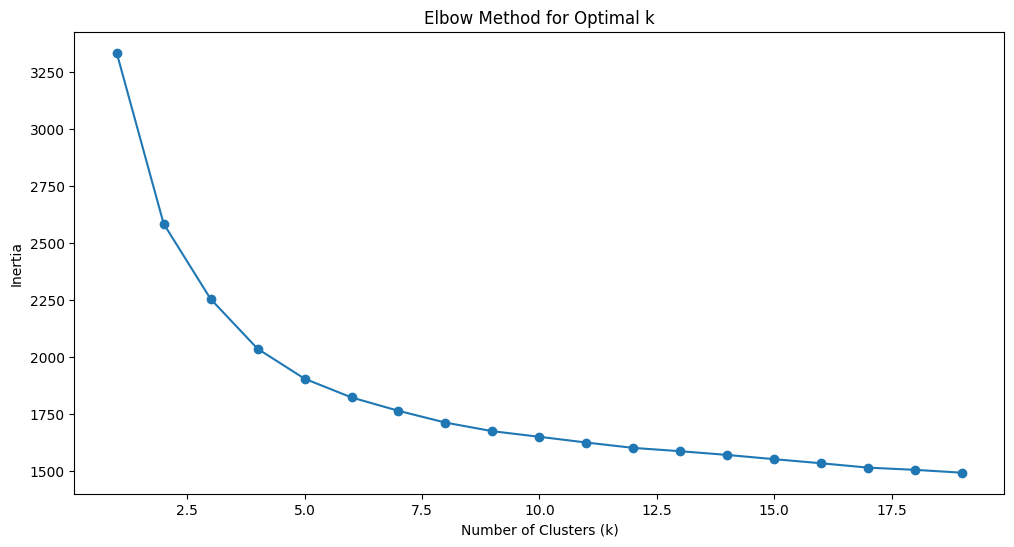

In [ ]:
# Plot the Elbow Curve
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

We're not able to see the elbow to define the number of clusters, so clustering on valid series' values over time is not meaningful, and model performance would be poor.

##Dynamic Time Warping


Dynamic Time Warping (DTW) is a dynamic programming technique that measures the distance between a pairwise of not synchronized time series; the goal is to find the optimal matching between similar elements of the time series. Again, for visualization purposes, without loss of generalization, only the first 1000 time series are considered. The full DTW distance matrix was computed locally.

In [ ]:
# Define a custom distance function using DTW
def dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

# Calculate pairwise DTW distances
dtw_distances = np.zeros((num_series, num_series))
for i in range(num_series):
    # print(i + 1, "of", num_series)
    for j in range(i + 1, num_series):
        dtw_distances[i, j] = dtw_distance(data[i, -last:], data[j, -last:])
        dtw_distances[j, i] = dtw_distances[i, j]

We now cluster series based on the DTW distance.

In [ ]:
# Perform hierarchical clustering using DTW distances
linkage_matrix = linkage(squareform(dtw_distances), method='average')

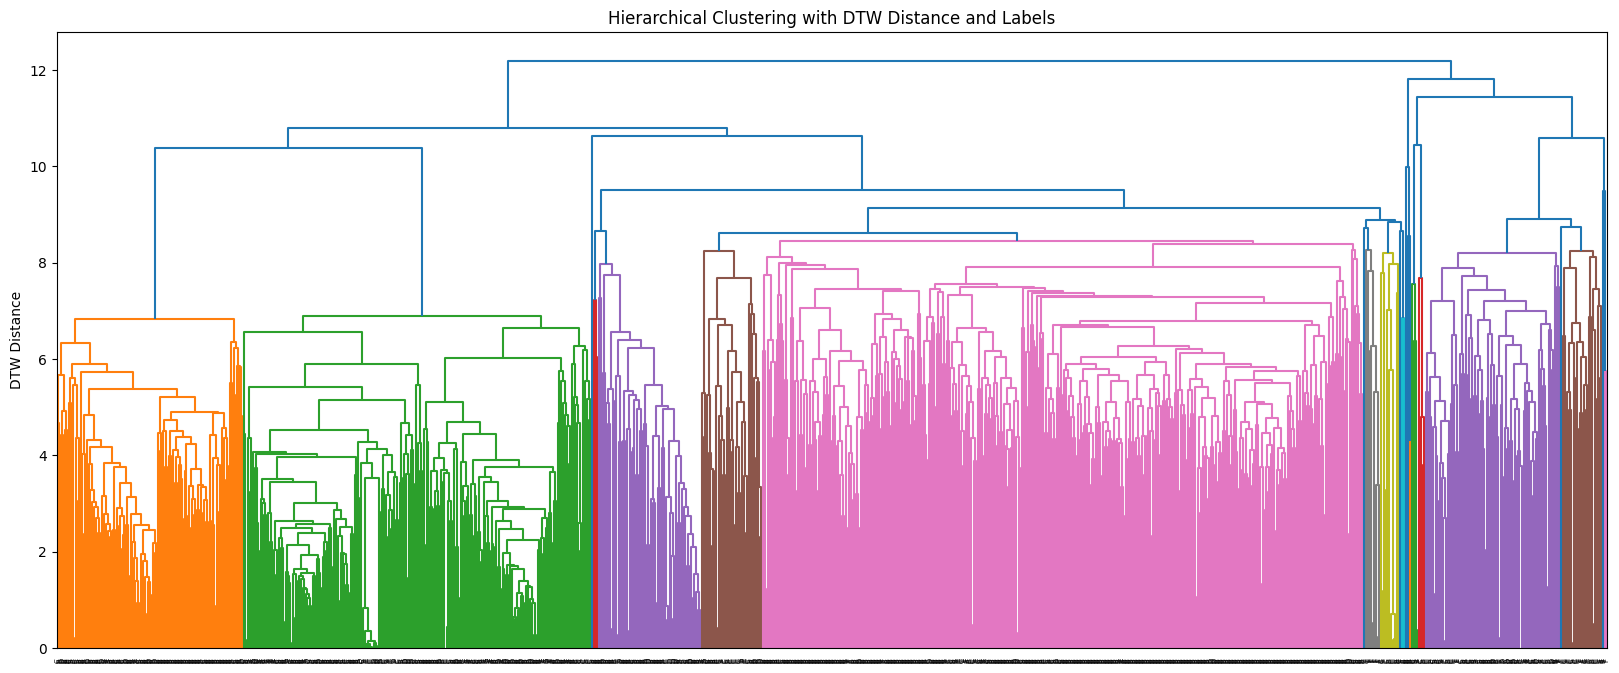

In [ ]:
# Plot the dendrogram with labels
plt.figure(figsize=(20, 8))
dendrogram(linkage_matrix, labels=categories, distance_sort='ascending', orientation='top')
plt.ylabel('DTW Distance')
plt.title('Hierarchical Clustering with DTW Distance and Labels')
plt.show()

In [ ]:
# Specify the number of clusters
num_clusters = 5

# Use fcluster to assign cluster labels to each data point
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Create a dictionary to store the count of leaves for each category in each cluster
cluster_counts = {cluster_num: {} for cluster_num in range(1, num_clusters + 1)}

# Count the number of leaves for each category in each cluster
for i, category in enumerate(categories):
    cluster_num = cluster_labels[i]
    if category not in cluster_counts[cluster_num]:
        cluster_counts[cluster_num][category] = 1
    else:
        cluster_counts[cluster_num][category] += 1

# Print the counts with categories sorted alphabetically
for cluster_num, counts_per_category in cluster_counts.items():
    sorted_counts = sorted(counts_per_category.items(), key=operator.itemgetter(0))  # Sort by category
    sorted_counts_str = ', '.join([f'{category}: {count}' for category, count in sorted_counts])
    print(f'Cluster {cluster_num}: {sorted_counts_str}')

plt.show()

Cluster 1: B: 237, C: 52, D: 33, E: 21, F: 2
Cluster 2: B: 420, C: 54, D: 25, E: 9, F: 17
Cluster 3: B: 4
Cluster 4: B: 4, C: 4, F: 1
Cluster 5: A: 1, B: 43, C: 47, D: 6, E: 3, F: 17


Given the high unbalance in the division of the series into clusters, and with respect to the categories as well, the clustering doesn't seem to be meaningful

In [ ]:
# Add a new column to your array with cluster labels
clustered_data = np.column_stack((data, cluster_labels))

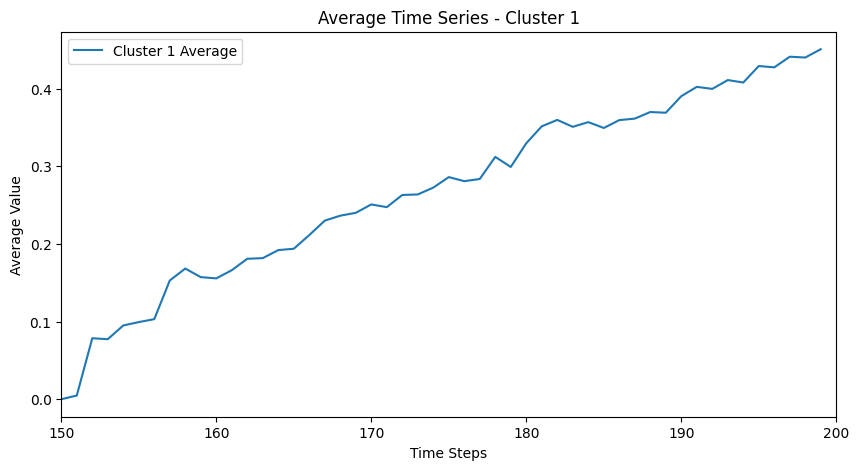

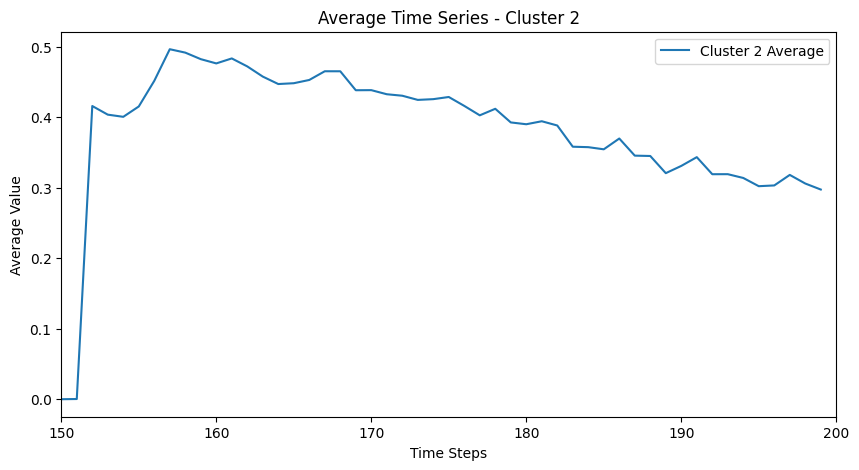

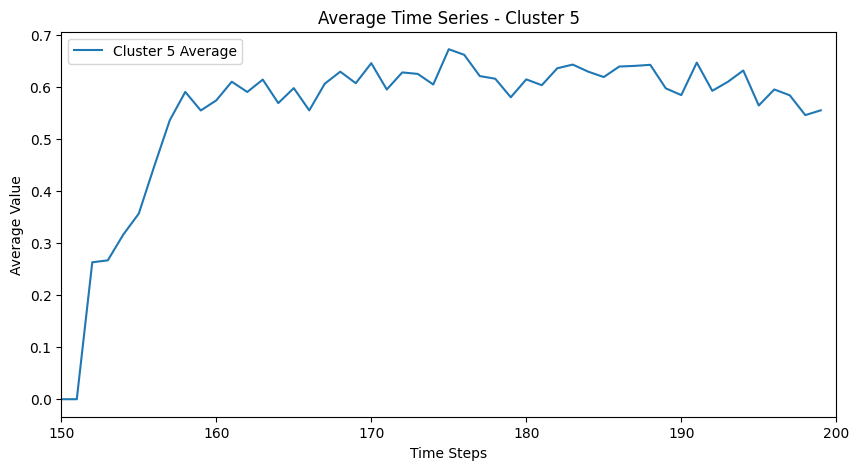

In [ ]:
# Iterate over each cluster and plot the average of all time series in that cluster
for cluster_num in range(1, num_clusters + 1):
    cluster_mask = clustered_data[:, -1] == cluster_num
    cluster_time_series = clustered_data[cluster_mask, :-1]

    if len(cluster_time_series) > 50:

      # Calculate the mean along the 0th axis (across all time series in the cluster)
      cluster_average = np.mean(cluster_time_series, axis=0)

      # Plot the average time series for the cluster
      plt.figure(figsize=(10, 5))
      plt.plot(cluster_average[-last:], label=f'Cluster {cluster_num} Average')

      plt.title(f'Average Time Series - Cluster {cluster_num}')
      plt.xlabel('Time Steps')
      plt.ylabel('Average Value')
      plt.xlim(150,200)
      plt.legend()
      plt.show()

In [ ]:
def plot_dendrogram(Z=None, model=None, X=None, figsize=(20,10), **kwargs):
    annotate = kwargs.pop('annotate', 0)
    if annotate:
        annotate_above = kwargs.pop('annotate_above', 0)

    # Reconstruct the linakge matrix if the standard model API was used
    # If Z not provided, the distance matrix is used to compute Z, instead of using directly the linkage matrix
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            # In older versions, 'metric' was called 'affinity'
            # Z = linkage(X, method=model.linkage, metric=model.affinity)
            Z = linkage(X, method=model.linkage, metric=model.metric)

    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above (+ 1e-6 of tolerance) the last but 'n_clusters' merge (column 2 is the distance)
        if annotate:
            kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-6
        else:
            kwargs['color_threshold'] = None

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram
    ddata = dendrogram(Z, ax=ax, **kwargs)

    # Annotate nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        nid = np.where(Z[:,2] == y)[0][0]
        # Optional above annotation
        if annotate:
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),
                textcoords='offset points', va='top', ha='center')
    if annotate and kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')

    return fig, ax

(<Figure size 2000x600 with 1 Axes>, <Axes: >)

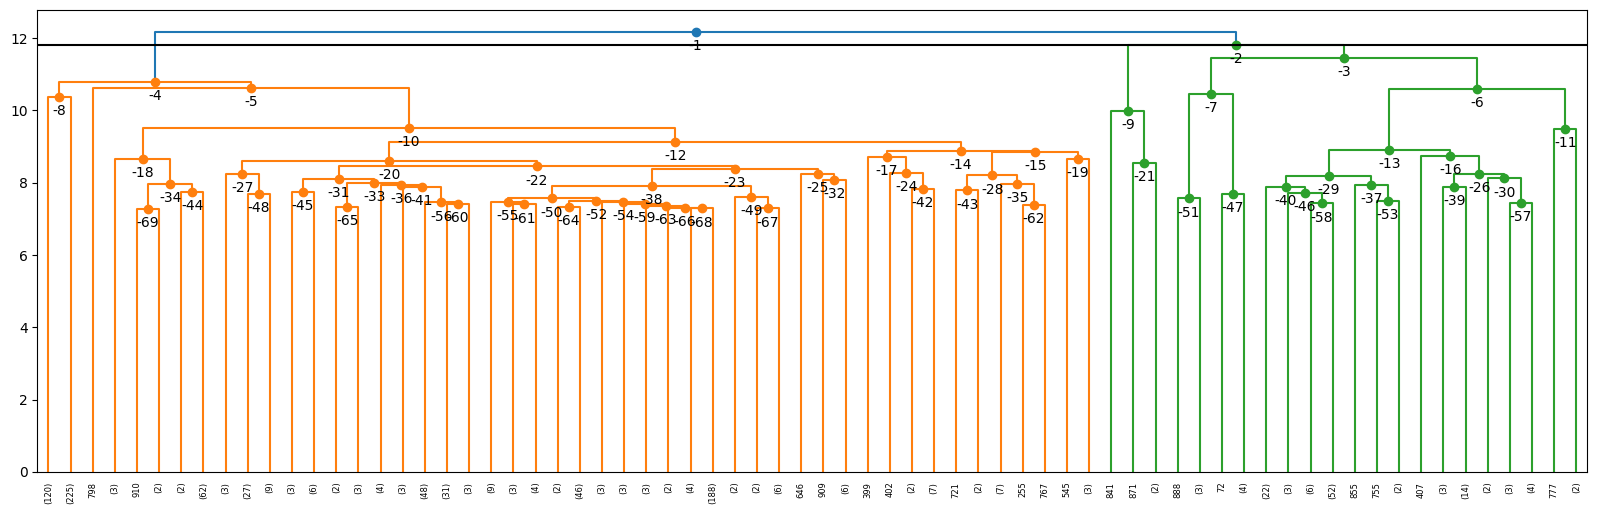

In [ ]:
plot_dendrogram(Z=linkage_matrix, figsize=(20,6), truncate_mode='lastp', p=70, n_clusters=2, annotate=True)

##Trend, periodicity and auto-correlation

The series seem to be highly heterogeneous, being ascending, descending, smooth, noisy, spiked, so we need a tool to uncover trends and patterns, by measuring the relationship between a variable’s present value and any past values. Also by inspecting the series we notice that they have a periodic behaviour, more or less evident in different series.

We can decompose the series into trend and seasonality: trends are continuous linear increases and decreases of the values over time, while the seasonality is the repeating of patterns or short-term cycles. These two terms are combined within the series and confused with the addition of residual noise. Also autocorrelation can be used, which is a statistical method that measures the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

In [ ]:
from statsmodels.tsa.seasonal import STL

The autocorrelation function (ACF) is calculated for the detrended series, and the absolute values of the ACF are sorted.
The function selects the `top_k` lags with the highest absolute autocorrelation values to be considered when analyzing the time series for periodic patterns. Higher values of `top_k` mean that more potential periodic patterns will be considered during the analysis. If we try with a higher `top_k`, the sensitivity increases, but this could also lead to false positives.

In [ ]:
def is_periodic(time_series, top_k=4, period=12, confidence_interval=0.95, max_length=50, idx=None, show_plot=True):

    if idx is not None and show_plot:
        print(f"Series {idx}")

    # Plot the tail of the time series
    if show_plot:
        plt.figure(figsize=(20, .8))
        plt.plot(time_series[-max_length:])
        plt.title('Original Time Series')
        plt.show()

    stl = STL(time_series, period=12)
    result = stl.fit()

    # Obtain the detrended series and the trend components
    detrended_series = result.seasonal
    trend = result.trend

    if show_plot:
        # Plot the detrended series
        plt.figure(figsize=(20, .8))
        plt.plot(detrended_series[-max_length:])
        plt.title('Detrended Series')
        plt.show()

    if show_plot:
        # Plot the trend series
        plt.figure(figsize=(20, .8))
        plt.plot(trend[-max_length:])
        plt.title('Trend Component')
        plt.show()

    # Calculate the autocorrelation function
    acf_values, conf_int = sm.tsa.acf(detrended_series, nlags=max_length-1, fft=False, alpha=1-confidence_interval)

    # Plot the ACF
    if show_plot:
        plt.figure(figsize=(20, 2))
        plt.stem(acf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title('Autocorrelation Function (ACF)')
        plt.axhline(y=0, linestyle='--', color='gray')  # Consider removing threshold line
        plt.show()

    # Choose the top k highest autocorrelation values
    top_k_indices = np.argsort(np.abs(acf_values))[-top_k:]
    top_k_lags = np.arange(max_length)[top_k_indices]

    if show_plot:
        print(f"Top {top_k} lags: {top_k_lags}")

    # Check if there exists a consistent periodic difference within the top k lags
    for i in range(len(top_k_lags)):
        for j in range(i + 1, len(top_k_lags)):
            lag_diff = top_k_lags[j] - top_k_lags[i]
            if lag_diff % period == 0:
                return True

    return False


In [ ]:
series_train_val, series_test, categories_train_val, categories_test = train_test_split(valid_series, unique_categories, random_state=seed, test_size=0.1, stratify=unique_categories)

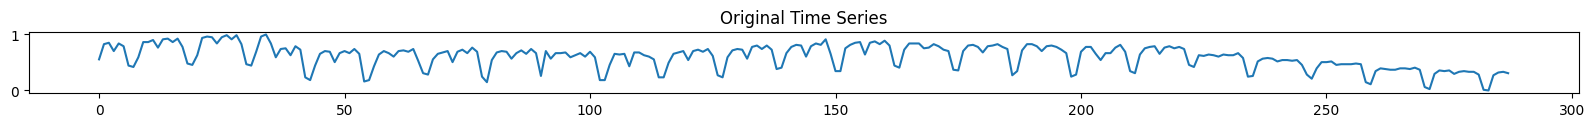

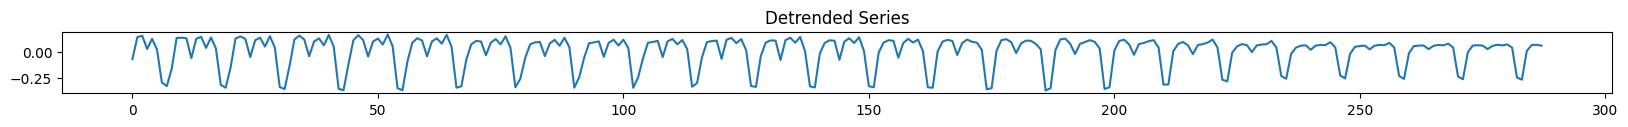

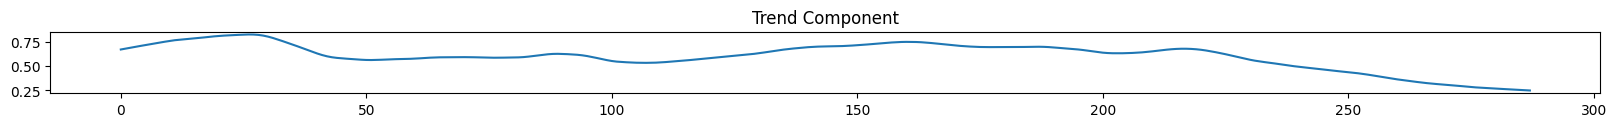

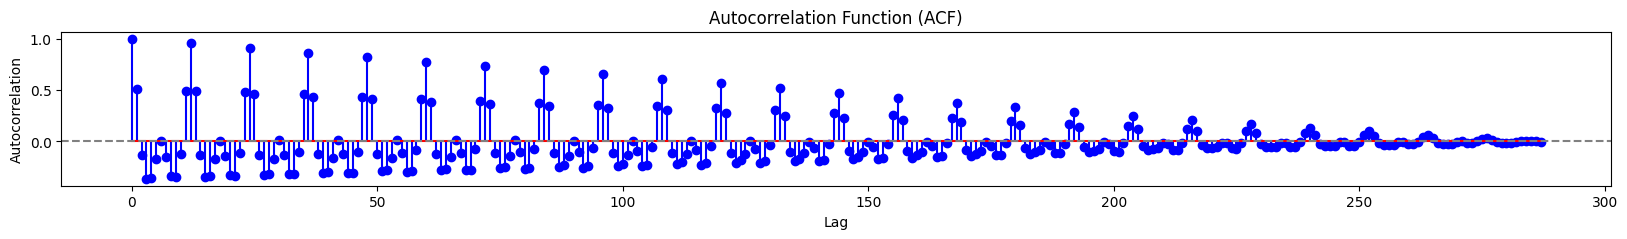

Top 4 lags: [36 24 12  0]
Is periodic: True


In [ ]:
# Example usage
time_series = series_train_val[105]
result = is_periodic(time_series, max_length=len(time_series))
print(f"Is periodic: {result}")

We see that autocorrelation shows spikes every 12 values, which seems reasonable given the economic area of the categories: the time records may be monthly, and show a periodic behaviour over years. By decomposing the series we observe the trend components which increases and decreases the average values, and the detrended components which are almost perfectly a periodic function. The original series is the sum of the two, since `STL` from `statsmodels` employes an additive decomposition algorithm.

In [ ]:
results = []
for i in range (len(series_train_val)):
  time_series = series_train_val[i]
  result = is_periodic(time_series, idx = i, debug = False, period = 12, top_k = 2)
  results.append(result)

In [ ]:
periodic_idx = [i for i, value in enumerate(results) if value]
non_periodic_idx = [i for i, value in enumerate(results) if not value]

print(f"{len(periodic_idx)} out of {len(series_train_val)} show a very strong periodic behaviour, {len(non_periodic_idx)}, i.e. the {(len(non_periodic_idx) / len(series_train_val) * 100):.2f} %, do not.")

35389 out of 43176 show a very strong periodic behaviour, 7787, i.e. the 18.04 %, do not.


Most of the series has a strong periodic behaviour (more than 80%), with a period of 12.

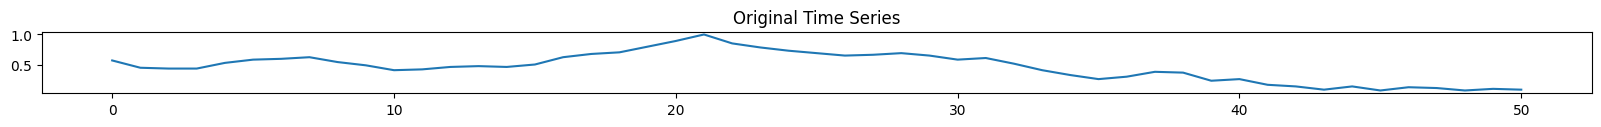

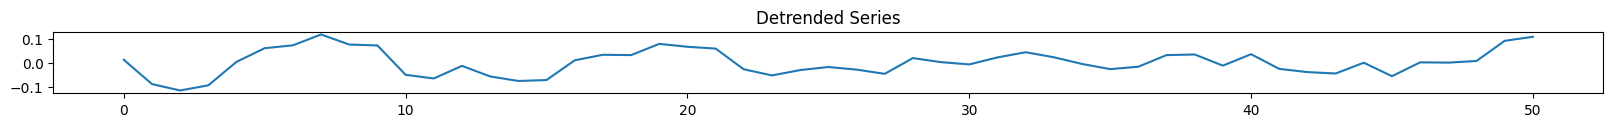

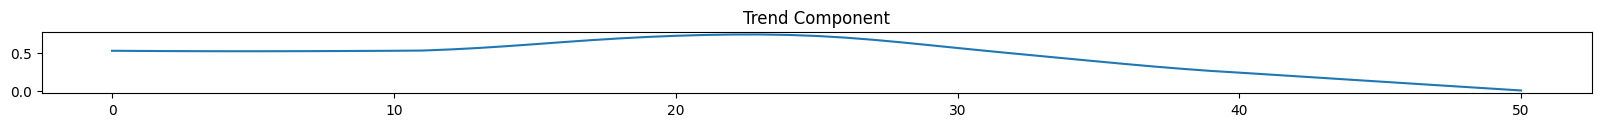

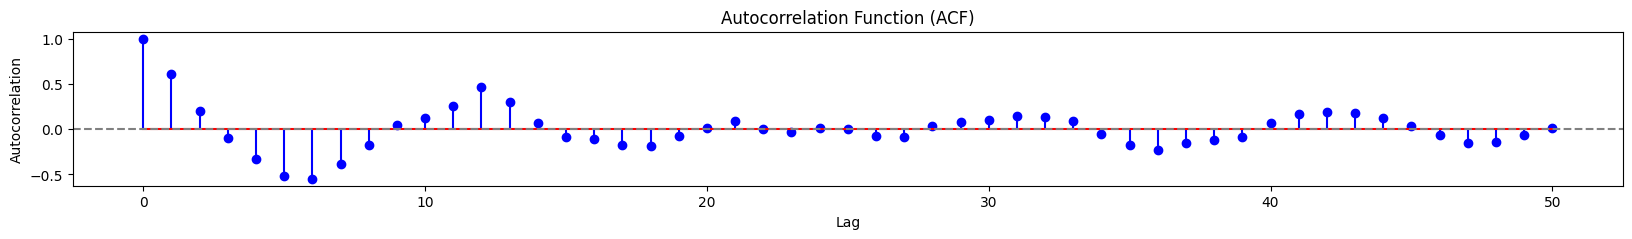

Top 4 lags: [5 6 1 0]
Is periodic: False


In [ ]:
time_series = series_train_val[non_periodic_idx[0]]
result = is_periodic(time_series, max_length=len(time_series))
print(f"Is periodic: {result}")

In [ ]:
result = is_periodic(time_series, max_length=len(time_series), top_k=5, show_plot=False)
print(f"Is periodic with a less stringent approach: {result}")

Is periodic with a less stringent approach: True


By using a less stringent definition of periodicity, all the series exhibits patterns every 12 timestamps.

In [ ]:
# Calculate mean autocorrelation and confidence intervals across all series for each lag
acf_values, conf_int = zip(*[sm.tsa.acf(STL(time_series, period=12).fit().seasonal, nlags=50-1, fft=False, alpha=0.05) for series in unique_series])

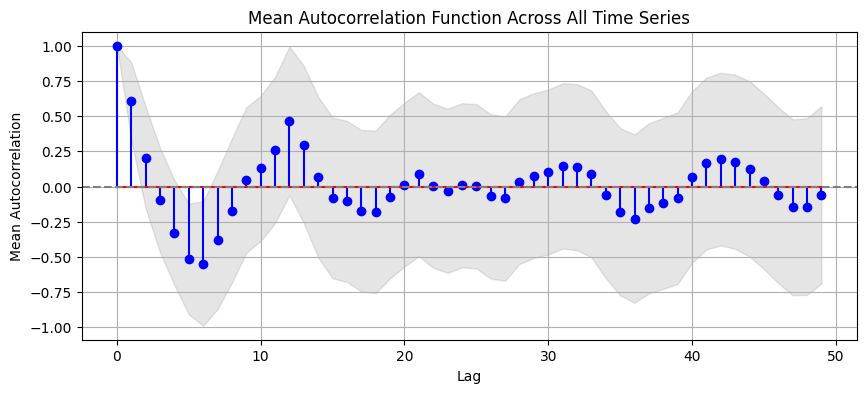

In [ ]:
# Convert to NumPy arrays
mean_acf_values = np.mean(acf_values, axis=0)
mean_conf_int = np.mean(conf_int, axis = 0)

# Plot the mean autocorrelation with confidence intervals
plt.figure(figsize=(10, 4))
plt.stem(mean_acf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.title('Mean Autocorrelation Function Across All Time Series')
plt.xlabel('Lag')
plt.ylabel('Mean Autocorrelation')
plt.grid(True)

# Plot confidence intervals
plt.axhline(y=0, linestyle='--', color='gray')
plt.fill_between(range(len(mean_acf_values)), mean_conf_int[:, 0], mean_conf_int[:, 1], color='gray', alpha=0.2)

plt.show()

### Examples of trend + seasonality decomposition

In [ ]:
# Split into train_validation and test sets
series_train_val, series_test, categories_train_val, categories_test = train_test_split(valid_series, unique_categories, random_state=seed, test_size=0.1, stratify=unique_categories)

# Print shapes of the datasets
print(f"series_train_val shape: {series_train_val.shape}, categories_train_val shape: {categories_train_val.shape}")
print(f"series_test shape: {series_test.shape}, categories_test shape: {categories_test.shape}\n")

# See if stratification was succesful
print(np.unique(categories_train_val, return_counts = True))
print(np.unique(categories_test, return_counts = True))

series_train_val shape: (43176,), categories_train_val shape: (43176,)
series_test shape: (4798,), categories_test shape: (4798,)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([5155, 9875, 9009, 9012, 9876,  249]))
(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'), array([ 573, 1097, 1001, 1002, 1097,   28]))


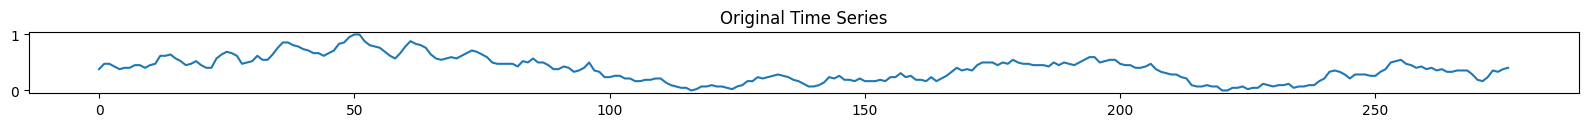

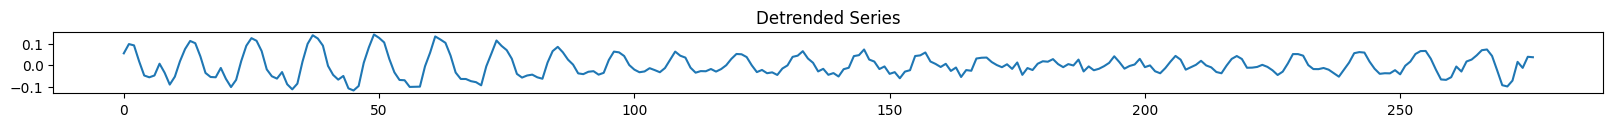

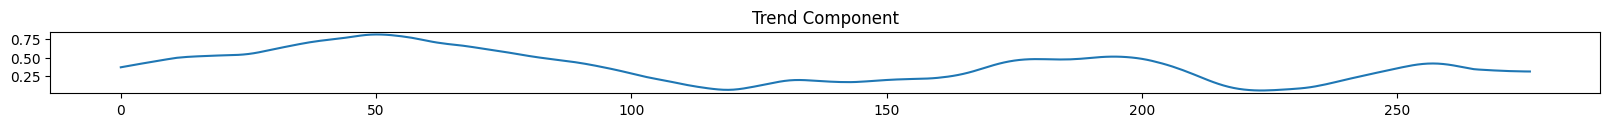

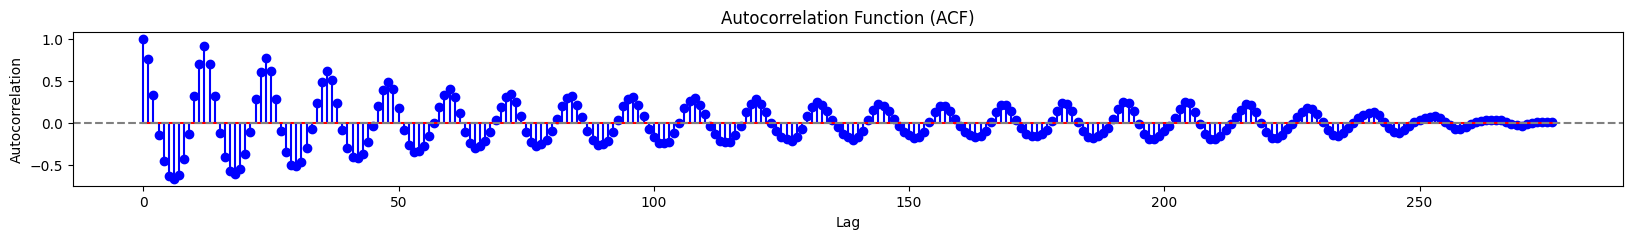

Top 4 lags: [ 1 24 12  0]


In [ ]:
_ = is_periodic(series_train_val[19], max_length=len(series_train_val[19]), show_plot=True)